<a href="https://colab.research.google.com/github/Vaibhav-Hariani/ECE-474-Bayesian/blob/main/ECE474Project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ECE-474 Project 1 - Conjugate Priors

In [ ]:
import numpy as np
import matplotlib.pyplot as plt, math

##Binomials

In [ ]:
rng = np.random.default_rng(0) #so results are repeatable
p_true   = 0.6
n_block  = 10 #each observation is a block of bernoulli trials
Ns       = np.array([1, 2, 5, 10, 20, 50, 100, 200]) #sample sizes
TRIALS   = 2000          # repeat the experiment to get a stable MSE

We are taking several sample sizes in "Ns" which we are going to sweep over the x-axis. We will use "N" observations. "TRIALS" replicate when computing the MSE as we want as many independent datasets at the same N for an average squared error. Each "observation" N, is a sample of binomial draws, where each sample contains n_block Bernoulli trials, and a success probability of p_true. We do these calculations in "blocks" to make the data less noisy per iteration, and also to  recognize a convergence faster towards the true mean.

In [ ]:
#hyperparameter choices
#for binomial p, the conjugate prior is Beta(alpha, beta)
binom_priors = [
    {"alpha": 1.0, "beta": 1.0, "label": "Conjugate Beta(1,1)"},
    {"alpha": 2.0, "beta": 2.0, "label": "Conjugate Beta(2,2)"},
    {"alpha": 5.0, "beta": 1.0, "label": "Conjugate Beta(5,1)"},
]

In [ ]:
#creating empty lists to store ML MSE and for Bayes Estimator across N
binom_ml_mse = []
binom_mse_by_prior = {p["label"]: [] for p in binom_priors}


In [ ]:
#calculating ML estimator and its MSE
for N in Ns: #for each sample size, each row is an experiment and each column is a binomial block
    counts = rng.binomial(n=n_block, p=p_true, size=(TRIALS, N))
    k = counts.sum(axis=1) #number of successes per experiment
    n_total = N * n_block #total trials in one experiment

    p_ml = k / n_total
    binom_ml_mse.append(np.mean((p_ml - p_true)**2))
    #calculating conjugate Bayes estimator and its MSE
    for prior in binom_priors: #with a Beta(alpha, beta) prior
        aN = prior["alpha"] + k #posterior with the number of successes
        bN = prior["beta"]  + (n_total - k) #posterior with the number of failures per experiment
        p_bayes = aN / (aN + bN)
        binom_mse_by_prior[prior["label"]].append(np.mean((p_bayes - p_true)**2)) #calculate MSE


We create a matrix of N independent binomial blocks, each containing trials. We recieve the ML fairly straightforwardly.

Starting with prior Beta(alpha, beta), after seeing k successes and n-k failures, we can get the posterior mean.

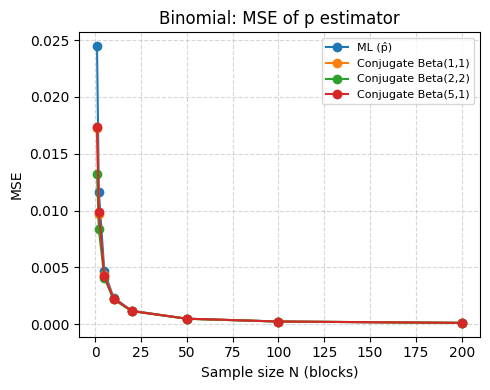

In [ ]:
plt.figure(figsize=(5, 4))
plt.plot(Ns, binom_ml_mse, marker='o', label="ML (p̂)")
for label, series in binom_mse_by_prior.items():
    plt.plot(Ns, series, marker='o', label=label)
plt.title("Binomial: MSE of p estimator")
plt.xlabel("Sample size N (blocks)")
plt.ylabel("MSE")
plt.legend(fontsize=8)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
#plot the posterior density for one hyperparameter prior pair
alpha0 = binom_priors[1]["alpha"]
beta0  = binom_priors[1]["beta"]
#create an independent binomial counts with true success
stream_counts = rng.binomial(n=n_block, p=p_true, size=max(Ns))


We take a look at one random sequence of observations, and look at what the posterior looks like. It is updated by adding observed successes or failures to prior counts.

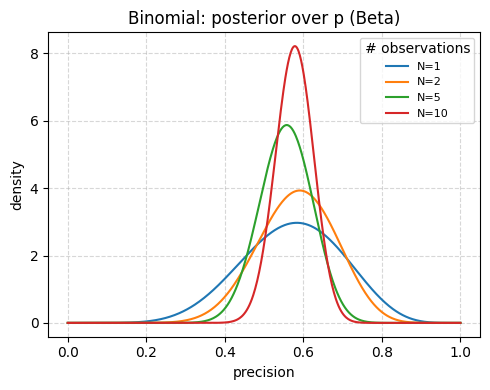

In [ ]:
Ns_short = Ns[:4] #use the four sample sizes to avoid clutter
plt.figure(figsize=(5,4))

for N in Ns_short:
    kN = int(stream_counts[:N].sum()) #total number of successes in first N trials
    n_total = N * n_block #total number of bernoulli
    aN = alpha0 + kN #calculate hyperparameters
    bN = beta0  + (n_total - kN)
    B = math.gamma(aN)*math.gamma(bN)/math.gamma(aN+bN) #beta function to normalize (gammafy) pdf
    pdf = (np.linspace(1e-6, 1-1e-6, 600)**(aN-1))*((1-np.linspace(1e-6, 1-1e-6, 600))**(bN-1)) / B
    plt.plot(np.linspace(1e-6, 1-1e-6, 600), pdf, label=f"N={N}") #N iterations curves

plt.title(r"Binomial: posterior over p (Beta)")
plt.xlabel(r"precision");
plt.ylabel("density")
plt.legend(title="# observations", fontsize=8);
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout();
plt.show()

At smaller N, the posterior is wider and is seen in the prior.
As N increases, the posterior concentrates around what p_true actually should be. Each peak of the curve shifts towards the true mean and the variance of the posterior density function shrinks.

## Mean estimator, variance known

In [ ]:
rng = np.random.default_rng(1)
#we set up true parameters to compare to
mean_true = 3.0
vars      = 4.0
precis    = 1.0 / vars #likelihood precision

In [ ]:
# we create prior means
gauss_mean_priors = [
    {"mean0": 0.0, "var0": 1.0,  "label": r"Conjugate $(\mu_0=0,\ \sigma_0^2=1)$"},
    {"mean0": 0.0, "var0": 10.0, "label": r"Conjugate $(\mu_0=0,\ \sigma_0^2=10)$"},
    {"mean0": 5.0, "var0": 1.0,  "label": r"Conjugate $(\mu_0=5,\ \sigma_0^2=1)$"},
]

In [ ]:
# storage for the mean estimator
gauss_mean_ml_mse = []
gauss_mean_mse_by_prior = {p["label"]: [] for p in gauss_mean_priors}

In [ ]:
for N in Ns: #each trial with N gaussian samples
    x = rng.normal(loc=mean_true, scale=np.sqrt(vars), size=(TRIALS, N)) #create normal distribution
    xbar = x.mean(axis=1) #find the mean of the normal distribution
    gauss_mean_ml_mse.append(np.mean((xbar - mean_true)**2)) #ML estimator

    for prior in gauss_mean_priors: #conjugate posterior
        percis0 = 1.0 / prior["var0"] #prior precision
        post_var = 1.0 / (percis0 + N * precis)
        post_mean = post_var * (percis0 * prior["mean0"] + N * precis * xbar)
        gauss_mean_mse_by_prior[prior["label"]].append(np.mean((post_mean - mean_true)**2))


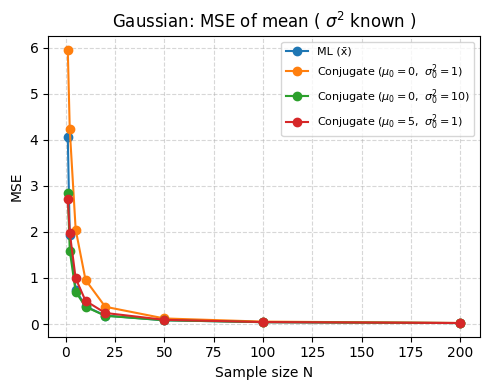

In [ ]:
# plot
plt.figure(figsize=(5,4))
plt.plot(Ns, gauss_mean_ml_mse, marker='o', label="ML (x̄)")
for label, series in gauss_mean_mse_by_prior.items():
    plt.plot(Ns, series, marker='o', label=label)
plt.title(r"Gaussian: MSE of mean ( $\sigma^2$ known )")
plt.xlabel("Sample size N")
plt.ylabel("MSE")
plt.legend(fontsize=8)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

For small N, the conjugate prior reduces the variance if it is close to the truth. So if the prior mean is poorly guessed, it can hurt small N. As N grows, both ML and Bayes converge.

In [ ]:
mean0 = gauss_mean_priors[1]["mean0"]
var0  = gauss_mean_priors[1]["var0"]
precis0 = 1.0 / var0

x_stream = rng.normal(loc=mean_true, scale=np.sqrt(vars), size=max(Ns_short))
cumsum_x = np.cumsum(x_stream)

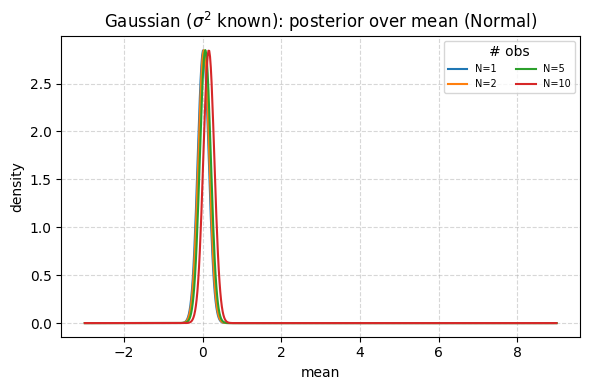

In [ ]:
plt.figure(figsize=(6,4))
for N in Ns_short:
    xbarN = cumsum_x[N-1] / N
    post_mean = post_var * (precis0 * mean0 + N * precis * xbarN)
    pdf = (1.0/np.sqrt(2*np.pi*post_var)) * np.exp(-(np.linspace(mean_true - 6, mean_true + 6, 600) - post_mean)**2/(2*post_var))
    plt.plot(np.linspace(mean_true - 6, mean_true + 6, 600), pdf, label=f"N={N}")

plt.title(r"Gaussian ($\sigma^2$ known): posterior over mean (Normal)")
plt.xlabel("mean"); plt.ylabel("density")
plt.legend(fontsize=7, ncol=2, title="# obs")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout(); plt.show()

We see that there is an underestimate of the true mean usually, but after every iteration, the observation increases and gets closer to the true mean.

# Mean Known, Variance Unknown
We assume that mean is fixed, and we want to infer the variance from the data.

In [ ]:
rng = np.random.default_rng(2)

In [ ]:
# conjugate prior for precision is a Gamma distribution with hyperparameters of a and b
gauss_var_priors = [
    {"a": 1.5, "b": 1.0, "label": r"Conjugate $\Gamma(a{=}1.5,b{=}1)$"},
    {"a": 2.5, "b": 1.0, "label": r"Conjugate $\Gamma(a{=}2.5,b{=}1)$"},
    {"a": 5.0, "b": 2.0, "label": r"Conjugate $\Gamma(a{=}5,b{=}2)$"},
]


In [ ]:
# storage of the MSEs
gauss_var_ml_mse = []
gauss_var_mse_by_prior = {p["label"]: [] for p in gauss_var_priors}

In [ ]:
for N in Ns: # N trials with Ns gaussian samples
    x = rng.normal(loc=mean_true, scale=np.sqrt(vars), size=(TRIALS, N)) #normal distribution with the true mean
    sse = np.sum((x - mean_true)**2, axis=1)  # sum of squared errors
    var_ml = sse / N # you can ML variance (mean known)
    gauss_var_ml_mse.append(np.mean((var_ml - vars)**2))
    # conjugate posterior Bayes estimator for variance which is also gamma
    for prior in gauss_var_priors:
        aN = prior["a"] + N/2.0
        bN = prior["b"] + 0.5 * sse
        # bayes estimator which is the precision given the gaussian distriubtion and the several mean samples
        var_bayes = bN / (aN - 1.0)
        gauss_var_mse_by_prior[prior["label"]].append(np.mean((var_bayes - vars)**2))

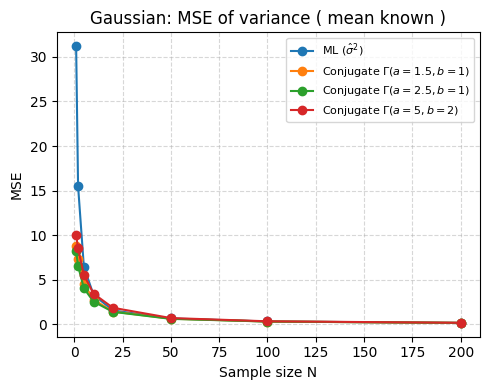

In [ ]:
plt.figure(figsize=(5,4))
plt.plot(Ns, gauss_var_ml_mse, marker='o', label=r"ML ($\hat{\sigma}^2$)")
for label, series in gauss_var_mse_by_prior.items():
    plt.plot(Ns, series, marker='o', label=label)
plt.title(r"Gaussian: MSE of variance ( mean known )")
plt.xlabel("Sample size N")
plt.ylabel("MSE")
plt.legend(fontsize=8)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
#plotting the posterior density function
a0 = gauss_var_priors[1]["a"]
b0 = gauss_var_priors[1]["b"]

#cumulative data stream
x_stream = rng.normal(loc=mean_true, scale=np.sqrt(vars), size=Ns_short)
sse_prefix = np.cumsum((x_stream - mean_true)**2)

lam_means = [] #create empty array for predicted means for that datastream

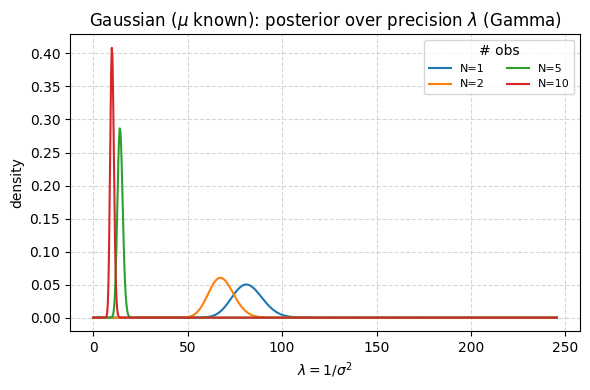

In [ ]:
for N in Ns_short:
    bN = b0 + 0.5 * sse_prefix[N-1]
    lam_means.append(aN / bN)
lam_hi = 3.0 * max(lam_means)
lam_grid = np.linspace(1e-6, lam_hi, 700)

plt.figure(figsize=(6,4))
for N in Ns_short:
    bN = b0 + 0.5 * sse_prefix[N-1]
    pdf = (bN**aN) / math.gamma(aN) * (lam_grid**(aN-1)) * np.exp(-bN * lam_grid)
    plt.plot(lam_grid, pdf, label=f"N={N}")

plt.title(r"Gaussian ($\mu$ known): posterior over precision $\lambda$ (Gamma)")
plt.xlabel(r"$\lambda = 1/\sigma^2$")
plt.ylabel("density")
plt.legend(title="# obs", fontsize=8, ncol=2)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout(); plt.show()